# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.nn import functional as F
from torchvision import datasets, models, transforms

from PIL import Image
import os

# Data Analysis 

In [2]:
path ='data/' #set here data directory

In [3]:
def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

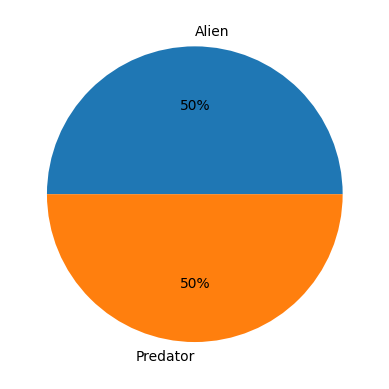

In [4]:
data=[count_files_in_directory(os.path.join(path, 'train/alien')), count_files_in_directory(os.path.join(path, 'train/predator'))]
keys=["Alien", "Predator"]
plt.pie(data, labels=keys, autopct='%.0f%%')

plt.show()

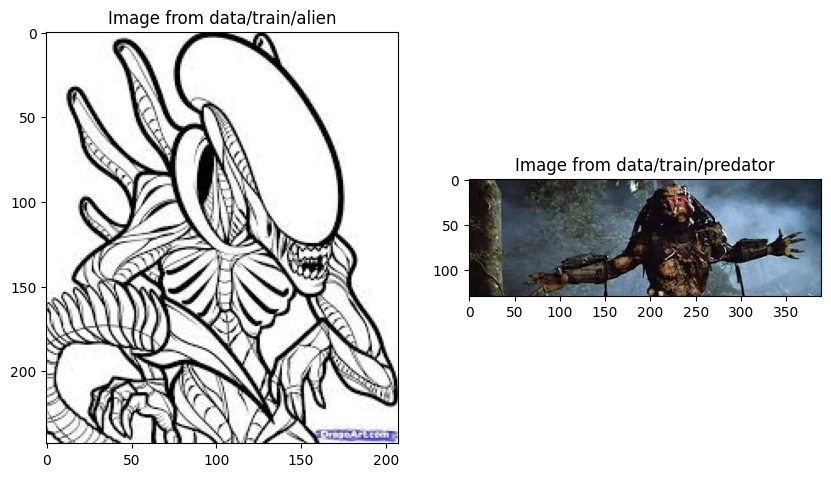

In [5]:
def display_random_images(path1, path2):
    files1 = os.listdir(path1)
    files2 = os.listdir(path2)
    
    img_name1 = random.choice(files1)
    img_name2 = random.choice(files2)
    
    img_path1 = os.path.join(path1, img_name1)
    img_path2 = os.path.join(path2, img_name2)
    
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f'Image from {path1}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f'Image from {path2}')
    
    plt.show()


display_random_images("data/train/alien", "data/train/predator")

In [6]:
#TODO Refactor - split for methods
def get_files_size():
    width = []
    height = []
    for direct in os.listdir(path):
        if direct != '.DS_Store': # applicable to MacOS
            for folder in os.listdir(os.path.join(path,direct)):
                if folder != '.DS_Store':
                    for file in os.listdir(os.path.join(path,direct ,folder)):
                        if file != '.DS_Store':
                            width.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
                            height.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
    return width, height

In [ ]:
#Mean size value from all pictures train+validation
width, height = get_files_size()
width = round(np.array(width).mean())
height =round(np.array(height).mean())
print(f'Dimensions for resize \nwidth: {width} \nheigth: {height}')

# Data preprocessing

In [8]:
class RandomHistogramNormalize:

    def __init__(self, number_bins: int = 256, p: float=0.5): # Lower number_bins made more noise
        self.number_bins = number_bins
        self.p = p

    def __call__(self, image: Image.Image) -> Image:
        if random.random() < self.p:

            image_np = np.array(image)

            image_histogram, bins = np.histogram(
                            image_np.flatten(), int(self.number_bins), density=True
            )
            cdf = image_histogram.cumsum()  
            cdf = 255 * cdf / cdf[-1]  
            image_equalized = np.interp(image_np.flatten(), bins[:-1], cdf)
            return Image.fromarray(image_equalized.reshape(image_np.shape).astype(np.uint8)) 
        else:
            return image

class RandomGaussianNoise:
    
    def __init__(self, p: float=0.5):
        self.p = p

    def __call__(self, sample: torch.Tensor) -> torch.Tensor:
        mu = sample.mean()
        snr = np.random.randint(low=4, high=8)
        sigma = mu / snr
        noise = torch.normal(torch.zeros(sample.shape), sigma)
        return sample + (random.random() < self.p) * noise


In [9]:
data_transforms = {
    'train':
    transforms.Compose([
        RandomHistogramNormalize(p=0.2), # Default random use with probability 50%
        transforms.Resize((width,height)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        RandomGaussianNoise(0.2), # Default random use with probability 50%
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((width,height)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'validation': 
    datasets.ImageFolder(os.path.join(path, 'validation'), data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False)
}

Text(0.5, 1.0, 'Epoch 4')

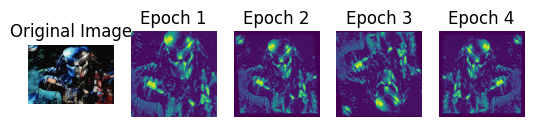

In [10]:
example_image_name = "train/predator/0.jpg"
example_image_path = os.path.join(path, example_image_name)
example_image = np.array(Image.open(example_image_path))
example_image_pil = Image.fromarray(example_image)

#One channel plot
augmented_image_1 = data_transforms['train'](example_image_pil).numpy()[0]
augmented_image_2 = data_transforms['train'](example_image_pil).numpy()[0]
augmented_image_3 = data_transforms['train'](example_image_pil).numpy()[0]
augmented_image_4 = data_transforms['train'](example_image_pil).numpy()[0]

#All channels plot just uncomment and delete "[0]" from previous block
# augmented_image_1 = np.transpose(augmented_image_1, (1, 2, 0))
# augmented_image_2 = np.transpose(augmented_image_2, (1, 2, 0))
# augmented_image_3 = np.transpose(augmented_image_3, (1, 2, 0))
# augmented_image_4 = np.transpose(augmented_image_4, (1, 2, 0))


fig, axs = plt.subplots(1, 5)

axs[0].imshow(example_image)
axs[0].set_axis_off()
axs[0].set_title("Original Image")

axs[1].imshow(augmented_image_1)
axs[1].set_axis_off()
axs[1].set_title("Epoch 1")

axs[2].imshow(augmented_image_2)
axs[2].set_axis_off()
axs[2].set_title("Epoch 2")

axs[3].imshow(augmented_image_3)
axs[3].set_axis_off()
axs[3].set_title("Epoch 3")

axs[4].imshow(augmented_image_4)
axs[4].set_axis_off()
axs[4].set_title("Epoch 4")

# Models

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" #Apple silicon
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [12]:
model_resnet18 = models.resnet18(weights='IMAGENET1K_V1').to(device)
    
for param in model_resnet18.parameters():
    param.requires_grad = False   
    
model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [13]:
class MultiClassCNN(nn.Module):
    def __init__(self):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model_MCCNN = MultiClassCNN().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()

## Train

In [15]:
def train_model(model, criterion, optimizer, num_epochs: int=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [16]:
num_epochs = 20 # Set number of Epochs

In [17]:
%%time
optimizer = optim.Adam(model_resnet18.fc.parameters())
model_resnet18 = train_model(model_resnet18, criterion, optimizer, num_epochs)

Epoch 1/20
----------
train loss: 0.5712, acc: 0.7219
validation loss: 0.4720, acc: 0.7200
Epoch 2/20
----------
train loss: 0.3425, acc: 0.8602
validation loss: 0.4863, acc: 0.7200
Epoch 3/20
----------
train loss: 0.3517, acc: 0.8444
validation loss: 0.2861, acc: 0.8900
Epoch 4/20
----------
train loss: 0.2932, acc: 0.8790
validation loss: 0.2756, acc: 0.8950
Epoch 5/20
----------
train loss: 0.2729, acc: 0.8790
validation loss: 0.2746, acc: 0.9000
Epoch 6/20
----------
train loss: 0.2483, acc: 0.9121
validation loss: 0.2726, acc: 0.8850
Epoch 7/20
----------
train loss: 0.2237, acc: 0.9049
validation loss: 0.2625, acc: 0.8900
Epoch 8/20
----------
train loss: 0.2706, acc: 0.8862
validation loss: 0.2569, acc: 0.8950
Epoch 9/20
----------
train loss: 0.2319, acc: 0.8991
validation loss: 0.2656, acc: 0.8850
Epoch 10/20
----------
train loss: 0.2239, acc: 0.9020
validation loss: 0.2842, acc: 0.8600
Epoch 11/20
----------
train loss: 0.1843, acc: 0.9251
validation loss: 0.2717, acc: 0.89

In [18]:
%%time
optimizer = optim.Adam(model_MCCNN.parameters())
model_MCCNN = train_model(model_MCCNN, criterion, optimizer, num_epochs)

Epoch 1/20
----------
train loss: 0.7812, acc: 0.5187
validation loss: 0.6680, acc: 0.5850
Epoch 2/20
----------
train loss: 0.6615, acc: 0.5893
validation loss: 0.5884, acc: 0.7150
Epoch 3/20
----------
train loss: 0.6525, acc: 0.6427
validation loss: 0.6460, acc: 0.6550
Epoch 4/20
----------
train loss: 0.6428, acc: 0.6470
validation loss: 0.5845, acc: 0.6700
Epoch 5/20
----------
train loss: 0.5867, acc: 0.6888
validation loss: 0.5807, acc: 0.6650
Epoch 6/20
----------
train loss: 0.5900, acc: 0.6816
validation loss: 0.5581, acc: 0.6950
Epoch 7/20
----------
train loss: 0.5597, acc: 0.7262
validation loss: 0.5796, acc: 0.6800
Epoch 8/20
----------
train loss: 0.5351, acc: 0.7349
validation loss: 0.5707, acc: 0.6750
Epoch 9/20
----------
train loss: 0.5134, acc: 0.7579
validation loss: 0.5827, acc: 0.7050
Epoch 10/20
----------
train loss: 0.5000, acc: 0.7378
validation loss: 0.5936, acc: 0.7050
Epoch 11/20
----------
train loss: 0.5144, acc: 0.7723
validation loss: 0.5507, acc: 0.71

## Predict

In [19]:
def plot_predictions(img_list, prediction, title):
    print(title)
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for i, img in enumerate(img_list):
        ax = axs[i]
        ax.axis('off')
        ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*prediction[i,0],100*prediction[i,1]))
        ax.imshow(img)

In [20]:
def predict(model, img_list, device, transforms):
    model.eval()
    test_batch = torch.stack([transforms(img).to(device) for img in img_list])
    outputs = model(test_batch)
    probs = F.softmax(outputs, dim=1)
    return probs.cpu().data.numpy()

In [21]:
test_img_paths = ["data/test/alien/0.jpg",
                "data/test/alien/1.jpg",
                "data/test/predator/0.jpg",
                "data/test/predator/1.jpg",
                ]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [22]:
predictions = predict(model_resnet18, img_list, device, data_transforms['validation']) #For test data using same preprocessing as for validation

ResNet18


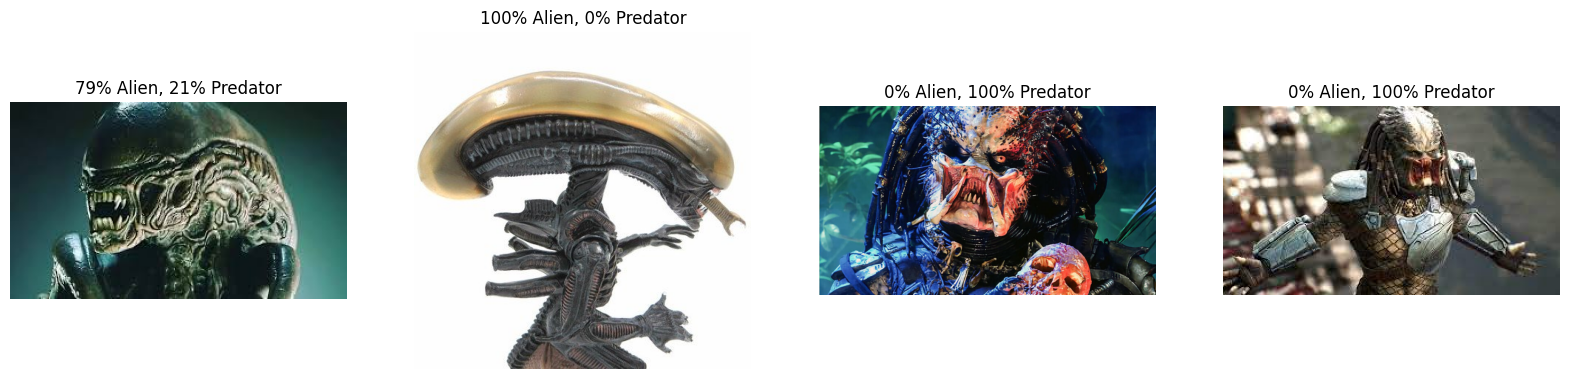

In [23]:
plot_predictions(img_list, predictions, "ResNet18")

In [24]:
predictions = predict(model_MCCNN, img_list, device, data_transforms['validation']) 

MultiClassCNN


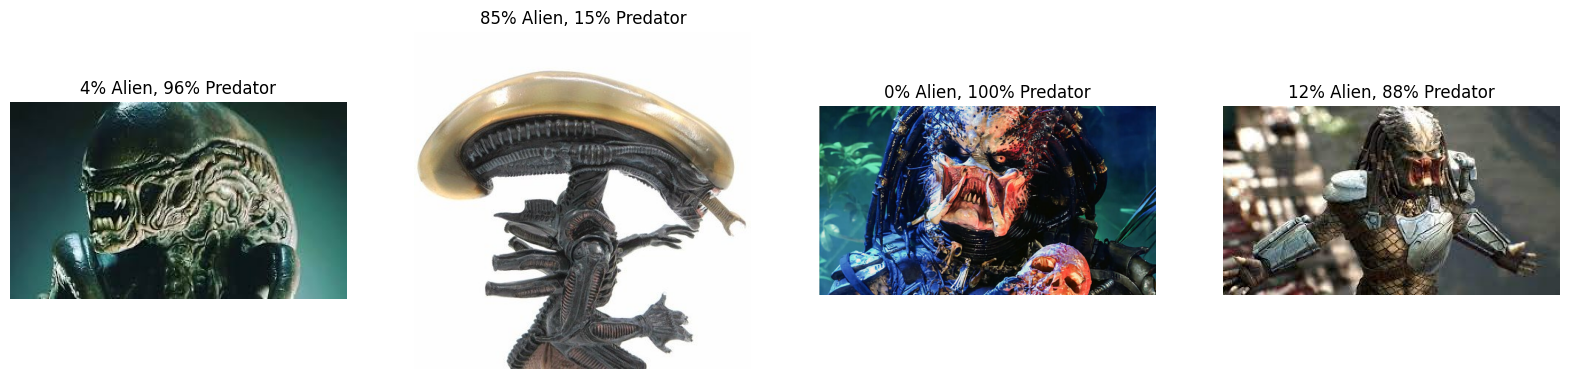

In [25]:
plot_predictions(img_list, predictions, "MultiClassCNN")

## Compare

In [26]:
def compare_models(model1, model2, dataloader):
    model1.eval()
    model2.eval()

    correct_model1 = 0
    correct_model2 = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs1 = model1(images)
            _, predicted1 = torch.max(outputs1.data, 1)

            outputs2 = model2(images)
            _, predicted2 = torch.max(outputs2.data, 1)

            total += labels.size(0)
            
            correct_model1 += (predicted1 == labels).sum().item()
            correct_model2 += (predicted2 == labels).sum().item()

    accuracy_model1 = correct_model1 / total
    accuracy_model2 = correct_model2 / total

    return accuracy_model1, accuracy_model2

In [27]:
res , cust = compare_models(model_resnet18, model_MCCNN, dataloaders['validation'])

results_dict = {"ResNet-18":res, "MultiClassCNN": cust}
df = pd.DataFrame([results_dict])
df.index= ['Accurancy']
df

,ResNet-18,MultiClassCNN
Accurancy,0.905,0.72


## Gradio

In [28]:
best_model = model_resnet18

def predict_image(image):
    class_names=['Alien', 'Predator']
    
    image = Image.fromarray(image)
    image = data_transforms['validation'](image).unsqueeze(0).to(device)   
    output = best_model(image)    
    probabilities = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
    
    return {class_name: float(probability) for class_name, probability in zip(class_names, probabilities)}


iface = gr.Interface(
    fn=predict_image, 
    inputs=gr.components.Image(shape=(width, height)), 
    outputs="label",
    title="Alien vs Predator",
)

iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://fb64ceb46a42001644.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
